### Given a Bank customer, can we build a classifier which can determine whether they will leave or not?

RowNumber
CustomerId
Surname
CreditScore
Geography
Gender
Age
Tenure
Balance
NumOfProductsHow many accounts, bank account affiliated products the person has
HasCrCard
IsActiveMemberSubjective, but for the concept
EstimatedSalary
ExitedDid they leave the bank after all?

### Load tensorflow

In [5]:
%tensorflow_version 2.x
from __future__ import absolute_import, division, print_function, unicode_literals

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

print(tf.__version__)

TensorFlow is already loaded. Please restart the runtime to change versions.
1.15.0


### Read the dataset in a new python notebook.

In [6]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/bank.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Drop the columns which are unique for all users like IDs

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
RowNumber          10000 non-null int64
CustomerId         10000 non-null int64
Surname            10000 non-null object
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


In [0]:
data.drop(['RowNumber','CustomerId','Surname'],axis=1,inplace=True)

Dropped Rownumber, customer id and Surname as this is not giving any learning about the data and is unique

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
CreditScore        10000 non-null int64
Geography          10000 non-null object
Gender             10000 non-null object
Age                10000 non-null int64
Tenure             10000 non-null int64
Balance            10000 non-null float64
NumOfProducts      10000 non-null int64
HasCrCard          10000 non-null int64
IsActiveMember     10000 non-null int64
EstimatedSalary    10000 non-null float64
Exited             10000 non-null int64
dtypes: float64(2), int64(7), object(2)
memory usage: 859.4+ KB


EDA

In [4]:
# Check the shape
rows, columns = data.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  10000
No of columns:  14


In [11]:
#missing values present
data.isnull().sum()

CreditScore        0
Geography          0
Gender             0
Age                0
Tenure             0
Balance            0
NumOfProducts      0
HasCrCard          0
IsActiveMember     0
EstimatedSalary    0
Exited             0
dtype: int64

In [0]:
### There are no missing values with total records 10000

In [13]:
data[['Exited']].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Exited,10000.0,0.2037,0.402769,0.0,0.0,0.0,0.0,1.0


In [0]:
# find minimum and maximum exited 

def find_min_max_rating():
    print('The minimum rating is: %d' %(data['Exited'].min()))
    print('The maximum rating is: %d' %(data['Exited'].max()))

In [15]:
find_min_max_rating() 

The minimum rating is: 0
The maximum rating is: 1


/usr/local/lib/python2.7/dist-packages/seaborn/categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


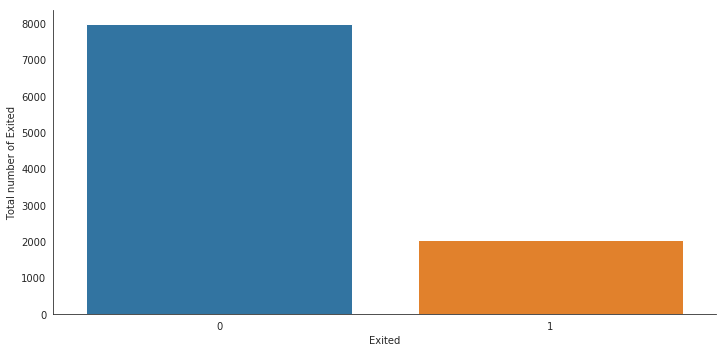

In [17]:
# Check the distribution of ratings 
with sns.axes_style('white'):
    g = sns.factorplot("Exited", data=data, aspect=2.0,kind='count')
    g.set_ylabels("Total number of Exited") 

In [18]:
# Number of unique user id and product id 
print('Number of unique having credit card data = ', data['HasCrCard'].nunique())
print('Number of unique is active member data = ', data['IsActiveMember'].nunique())

Number of unique having credit card data =  2
Number of unique is active member data =  2


In [19]:
maxnosofproduct = data.groupby('NumOfProducts').size().sort_values(ascending=False)[:10]
maxnosofproduct

NumOfProducts
1    5084
2    4590
3     266
4      60
dtype: int64

# Distinguish the feature and target set

In [20]:
if data.isnull().values.any() == False:
    print("There are no nulls/NaN values in our data frame")

There are no nulls/NaN values in our data frame


In [21]:
PredictColumn="Exited"

data.groupby(PredictColumn).count()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
Exited,,,,,,,,,,
0,7963,7963,7963,7963,7963,7963,7963,7963,7963,7963
1,2037,2037,2037,2037,2037,2037,2037,2037,2037,2037


In [0]:
from sklearn import preprocessing
non_numeric_columns=data.select_dtypes(include=["object"]).columns
for c in non_numeric_columns:
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(data[c].values))
        data[c] = lbl.transform(list(data[c].values))

In [23]:
data.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [24]:
#One hot encoding. 

from keras.utils import to_categorical
encoded = pd.DataFrame(to_categorical(data.iloc[:, 1]))
#no need to encode Gender, as there are only two categories

data = pd.concat([encoded, data], axis = 1)
data.rename({1:"G1",2:"G2"},axis=1,inplace=True)
data.head()
data = data.drop(['Geography', 0], axis = 1)

Using TensorFlow backend.


In [25]:
data.head()

,G1,G2,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.0,0.0,619,0,42,2,0.00,1,1,1,101348.88,1
1,0.0,1.0,608,0,41,1,83807.86,1,0,1,112542.58,0
2,0.0,0.0,502,0,42,8,159660.80,3,1,0,113931.57,1
3,0.0,0.0,699,0,39,1,0.00,2,0,0,93826.63,0
4,0.0,1.0,850,0,43,2,125510.82,1,1,1,79084.10,0


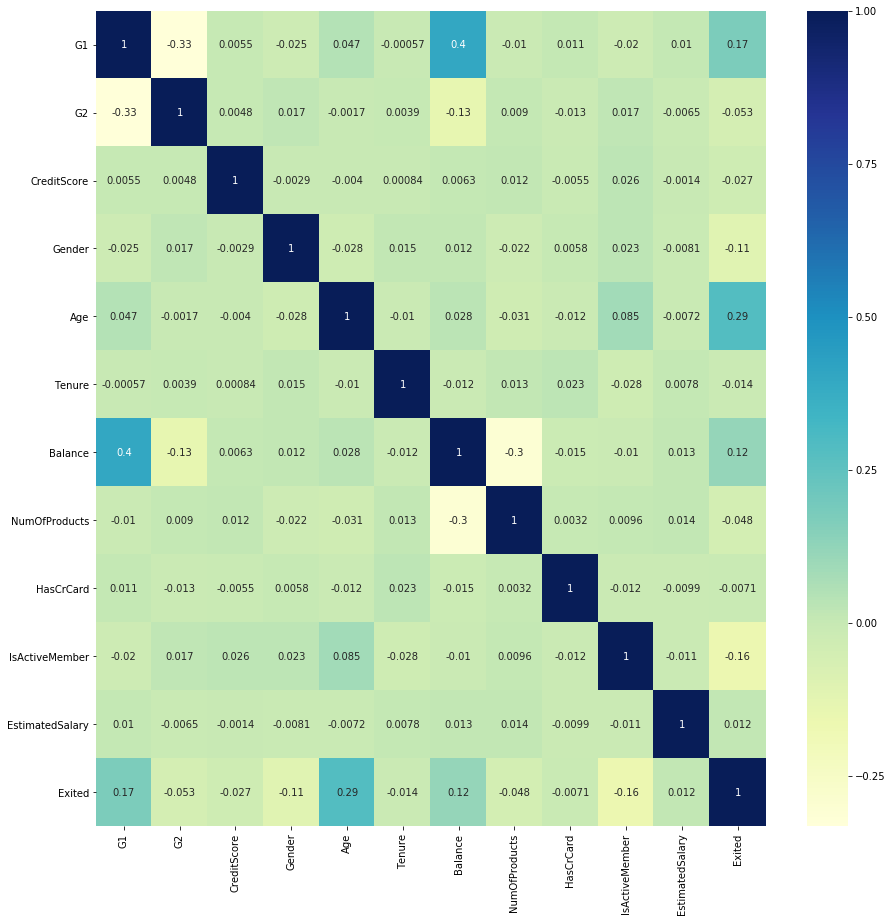

In [26]:
plt.figure(figsize = (15,15))
sns.heatmap(data.corr(), annot = True, cmap = 'YlGnBu' )

In [27]:
X=pd.DataFrame()
for cols in data.columns:
    if cols!=PredictColumn:
        X[cols]=data[cols]
X.shape

(10000, 11)

In [28]:
Y = data[PredictColumn]
Y.shape

(10000,)

## Divide the data set into Train and test sets

In [0]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.20)

In [30]:
test_y.shape

(2000,)

In [31]:
train_x.shape

(8000, 11)

In [32]:
test_x.shape

(2000, 11)

In [33]:
train_y.head()

3251    1
889     0
6468    0
2412    0
6184    1
Name: Exited, dtype: int64

In [34]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
train_x = sc.fit_transform(train_x)
test_x = sc.transform(test_x)

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python2.7/dist-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning: Data with input dtype int64, float32, float64 were all converted to float64 by StandardScaler.
  after removing the cwd from sys.path.


In [0]:
train_x=pd.DataFrame(train_x)

## Normalize the train and test data 



### Model 1 - Build a neural Network with 1 hidden layer and 1 output layer and adam with loss function as binary_crossentropy optimizer in Keras. The output layer with 1 neurons as we have 1 classes.

### Execute the model using model.fit()

In [37]:
model1 = keras.Sequential([
    keras.layers.Flatten(input_shape=(11,)),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
model1.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model1.fit(train_x, train_y, epochs=10)

Train on 8000 samples
Epoch 1/10
8000/8000 [==============================] - 0s 39us/sample - loss: 0.5308 - acc: 0.7872
Epoch 2/10
8000/8000 [==============================] - 0s 34us/sample - loss: 0.4769 - acc: 0.7931
Epoch 3/10
8000/8000 [==============================] - 0s 33us/sample - loss: 0.4511 - acc: 0.7977
Epoch 4/10
8000/8000 [==============================] - 0s 31us/sample - loss: 0.4383 - acc: 0.8020
Epoch 5/10
8000/8000 [==============================] - 0s 32us/sample - loss: 0.4311 - acc: 0.8074
Epoch 6/10
8000/8000 [==============================] - 0s 32us/sample - loss: 0.4265 - acc: 0.8108
Epoch 7/10
8000/8000 [==============================] - 0s 33us/sample - loss: 0.4231 - acc: 0.8148
Epoch 8/10
8000/8000 [==============================] - 0s 32us/sample - loss: 0.4204 - acc: 0.8177
Epoch 9/10
8000/8000 [==============================] - 0s 34us/sample - loss: 0.4179 - acc: 0.8185
Epoch 10/10
8000/8000 [==============================] - 0s 31us/sample - loss

In [38]:
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 11)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 7         
Total params: 79
Trainable params: 79
Non-trainable params: 0
_________________________________________________________________
None


In [39]:
# Test on unseen data

test_loss, test_acc = model1.evaluate(test_x,test_y, verbose=2)

print('\nTest accuracy:', test_acc)

2000/2000 - 0s - loss: 0.4136 - acc: 0.8195

Test accuracy: 0.8195


Model 2 - In the above Neural Network model add Batch Normalization layer after the input layer and repeat the steps.

In [41]:
model2 = keras.Sequential([
    keras.layers.Flatten(input_shape=(11,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
adam=keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model2.compile(optimizer=adam,
              loss='binary_crossentropy',
              metrics=['accuracy'])
model2.fit(train_x, train_y, epochs=10)

Train on 8000 samples
Epoch 1/10
8000/8000 [==============================] - 0s 49us/sample - loss: 0.6590 - acc: 0.6488
Epoch 2/10
8000/8000 [==============================] - 0s 39us/sample - loss: 0.5050 - acc: 0.7791
Epoch 3/10
8000/8000 [==============================] - 0s 37us/sample - loss: 0.4521 - acc: 0.7934
Epoch 4/10
8000/8000 [==============================] - 0s 38us/sample - loss: 0.4322 - acc: 0.8050
Epoch 5/10
8000/8000 [==============================] - 0s 37us/sample - loss: 0.4214 - acc: 0.8166
Epoch 6/10
8000/8000 [==============================] - 0s 37us/sample - loss: 0.4148 - acc: 0.8209
Epoch 7/10
8000/8000 [==============================] - 0s 38us/sample - loss: 0.4094 - acc: 0.8292
Epoch 8/10
8000/8000 [==============================] - 0s 37us/sample - loss: 0.4057 - acc: 0.8311
Epoch 9/10
8000/8000 [==============================] - 0s 38us/sample - loss: 0.4007 - acc: 0.8359
Epoch 10/10
8000/8000 [==============================] - 0s 37us/sample - loss

In [42]:
# Test on unseen data

test_loss, test_acc = model2.evaluate(test_x,test_y, verbose=2)

print('\nTest accuracy:', test_acc)

2000/2000 - 0s - loss: 0.3868 - acc: 0.8395

Test accuracy: 0.8395


In [43]:
print(model2.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_3 (Flatten)          (None, 11)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 11)                44        
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 72        
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 7         
Total params: 123
Trainable params: 101
Non-trainable params: 22
_________________________________________________________________
None



Model 3 - Customize the activation function to softmax learning rate to 0.001 in sgd optimizer and run the model

In [0]:
from keras import optimizers
model3 = keras.Sequential([
    keras.layers.Flatten(input_shape=(11,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(1, activation='softmax')
])
sgd = tf.keras.optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.9, nesterov=True)

In [47]:
model3.compile(loss='binary_crossentropy', optimizer=sgd,metrics=['accuracy'])
model3.fit(train_x, train_y, epochs=10)

Train on 8000 samples
Epoch 1/10
8000/8000 [==============================] - 0s 53us/sample - loss: 12.1957 - acc: 0.2046
Epoch 2/10
8000/8000 [==============================] - 0s 41us/sample - loss: 12.1957 - acc: 0.2046
Epoch 3/10
8000/8000 [==============================] - 0s 40us/sample - loss: 12.1957 - acc: 0.2046
Epoch 4/10
8000/8000 [==============================] - 0s 41us/sample - loss: 12.1957 - acc: 0.2046
Epoch 5/10
8000/8000 [==============================] - 0s 41us/sample - loss: 12.1957 - acc: 0.2046
Epoch 6/10
8000/8000 [==============================] - 0s 41us/sample - loss: 12.1957 - acc: 0.2046
Epoch 7/10
8000/8000 [==============================] - 0s 38us/sample - loss: 12.1957 - acc: 0.2046
Epoch 8/10
8000/8000 [==============================] - 0s 41us/sample - loss: 12.1957 - acc: 0.2046
Epoch 9/10
8000/8000 [==============================] - 0s 38us/sample - loss: 12.1957 - acc: 0.2046
Epoch 10/10
8000/8000 [==============================] - 0s 39us/samp

In [48]:
print(model3.summary())

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_5 (Flatten)          (None, 11)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 11)                44        
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 72        
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 7         
Total params: 123
Trainable params: 101
Non-trainable params: 22
_________________________________________________________________
None


In [49]:
# Test on unseen data

test_loss, test_acc = model3.evaluate(test_x,  test_y, verbose=2)

print('\nTest accuracy:', test_acc)

2000/2000 - 0s - loss: 12.1994 - acc: 0.2000

Test accuracy: 0.2


Model is very poor

Model 4 - Build the Neural Network model with 3 Dense layers with 6,2,1 neurons respectively in each layer. Use cross entropy loss function and relu as activation in the hidden layers and sigmoid as activation function in the output layer. Use sgd optimizer with learning rate 0.03. Increase Epoc to 100 and batch size to 32

In [65]:
tf.keras.backend.clear_session()
from keras import optimizers
model4 = keras.Sequential([
    keras.layers.Flatten(input_shape=(11,)),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(6, activation='relu'),
    keras.layers.Dense(2, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])
adam=keras.optimizers.Adam(learning_rate=0.03, beta_1=0.9, beta_2=0.999, amsgrad=False)

model4.compile(optimizer=adam, loss="binary_crossentropy", metrics=["accuracy"])

mckpt = tf.keras.callbacks.ModelCheckpoint('./mnist_v1.h5', 
                                           monitor='val_acc', save_best_only=True)
model4.fit(train_x, train_y, epochs=10)
model4.fit(train_x,train_y,          
          validation_data=(train_x,train_y),
          epochs=100,
          batch_size=32, callbacks=[mckpt])

Train on 8000 samples
Epoch 1/10
8000/8000 [==============================] - 0s 51us/sample - loss: 0.4414 - acc: 0.8086
Epoch 2/10
8000/8000 [==============================] - 0s 39us/sample - loss: 0.3887 - acc: 0.8424
Epoch 3/10
8000/8000 [==============================] - 0s 39us/sample - loss: 0.3727 - acc: 0.8526
Epoch 4/10
8000/8000 [==============================] - 0s 39us/sample - loss: 0.3665 - acc: 0.8480
Epoch 5/10
8000/8000 [==============================] - 0s 39us/sample - loss: 0.3685 - acc: 0.8520
Epoch 6/10
8000/8000 [==============================] - 0s 40us/sample - loss: 0.3707 - acc: 0.8493
Epoch 7/10
8000/8000 [==============================] - 0s 40us/sample - loss: 0.3677 - acc: 0.8515
Epoch 8/10
8000/8000 [==============================] - 0s 39us/sample - loss: 0.3642 - acc: 0.8537
Epoch 9/10
8000/8000 [==============================] - 0s 39us/sample - loss: 0.3633 - acc: 0.8528
Epoch 10/10
8000/8000 [==============================] - 0s 40us/sample - loss

## Review model

In [66]:
print(model4.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 11)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 11)                44        
_________________________________________________________________
dense (Dense)                (None, 6)                 72        
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 14        
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 3         
Total params: 133
Trainable params: 111
Non-trainable params: 22
_________________________________________________________________
None


### Run the model

In [67]:
test_loss, test_acc = model4.evaluate(test_x,  test_y, verbose=2)

print('\nTest accuracy:', test_acc)

2000/2000 - 0s - loss: 0.3484 - acc: 0.8580

Test accuracy: 0.858


Model 1 - Build a neural Network with 1 hidden layer and 1 output layer and adam with loss function as binary_crossentropy optimizer in Keras. The output layer with 1 neurons as we have 1 classes.
Test accuracy: 0.8195

Model 2 - In the above Neural Network model add Batch Normalization layer after the input layer and repeat the steps.
Test accuracy: 0.8395

Model 3 - Customize the activation function to softmax learning rate to 0.001 in sgd optimizer and run the model

Test accuracy: 0.2

Model 4 - Build the Neural Network model with 3 Dense layers with 6,2,1 neurons respectively in each layer. Use cross entropy loss function and relu as activation in the hidden layers and sigmoid as activation function in the output layer. Use sgd optimizer with learning rate 0.03. Increase Epoc to 100 and batch size to 32
Test accuracy: 0.858

Model 4 is better performing with 85% accuracy

## Adjusting the classification threshold

In [100]:
model4.predict(test_x)

array([[0.08740044],
       [0.01208925],
       [0.12225044],
       ...,
       [0.20312259],
       [0.015095  ],
       [0.19450822]], dtype=float32)

In [69]:
# print the first 10 predicted probabilities of class membership
model4.predict_proba(test_x)[0:10]

array([[0.08740044],
       [0.01208925],
       [0.12225044],
       [0.35308403],
       [0.02267706],
       [0.24857011],
       [0.08017766],
       [0.02503762],
       [0.26221442],
       [0.24789572]], dtype=float32)

In [0]:
# print the first 10 predicted probabilities for class 1
y_pred_prob = model4.predict_proba(test_x)[:]

In [0]:
# allow plots to appear in the notebook
%matplotlib inline
import matplotlib.pyplot as plt

# adjust the font size 
plt.rcParams['font.size'] = 12

Text(0,0.5,u'Frequency')

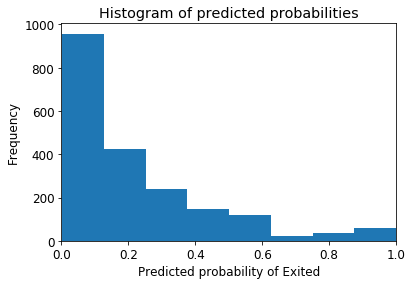

In [107]:
#histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Exited')
plt.ylabel('Frequency')

In [0]:
i=0
for predicted in enumerate(y_pred_prob):
    if y_pred_prob[i] > 0.5:
        y_pred_prob[i]=1
    else:
        y_pred_prob[i]=0
    i=i+1

Text(0,0.5,u'Frequency')

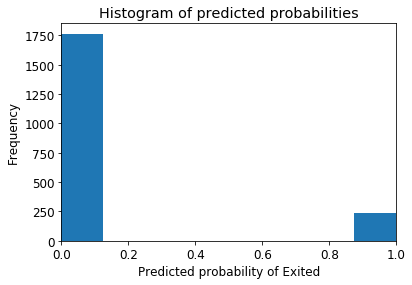

In [117]:
#histogram of predicted probabilities

# 8 bins
plt.hist(y_pred_prob, bins=8)

# x-axis limit from 0 to 1
plt.xlim(0,1)
plt.title('Histogram of predicted probabilities')
plt.xlabel('Predicted probability of Exited')
plt.ylabel('Frequency')

In [116]:
# print the first 10 predicted probabilities
y_pred_prob[0:10]

array([[0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.],
       [0.]], dtype=float32)

In [114]:
# new confusion matrix (threshold of 0.3)
from sklearn.metrics import confusion_matrix, accuracy_score
print(confusion_matrix(test_y, y_pred_prob))

[[1540   60]
 [ 224  176]]


In [115]:
print(accuracy_score(test_y, y_pred_prob))

0.858




---

# Inference: Model 4 is giving better accuracy with 85.8. Also threshold of 0.5 has no impact on accuracy, it still remains as 85.8